# Inferential Statistics and Explainatory Data Analysis (EDA) of Cervix Type Images Dataset from the Intel & MobileODT Cervical Cancer Screening

### By: Huong Ivy Nguyen, Ph.D. 

# INTRODUCTION
This project is inspried by a Kaggle competition hosted by Intel & Mobile ODT. This main idea is to build an effective algorithm that can determine the type of cervix a patient has. This would help healthcare provider makes better treatment decisions for cervical cancer patients. During this EDA process, I want to determine the following facts about the given training and testing dataset:
+ Whether all images were taken by the same make/model camera. If all images were not taken by the same camera, is there any difference in term of image resolution between one and another?
+ Is there any particular timeframe that the images were taken the most? 
+ How does the averge image of one class (Type 1 versus Type 2 versus Type 3) have any distinct differences from the average images of the other classes?
+ What are the min/max images based on ranking the vector norms?
+ Can we conduct any image structructual similarity test? (usge of mean squared error and structural similarity index (ssim))?

The following code is used to query, visualize, and test both the training and the testing dataset in order to explore the above questions. The following features were extracted and imported into csv files for both training and testing dataset during the data wrangling step:
+ image sizes
+ image filename
+ the corresponding cervix type (target)

# EDA Part

## I. EDA Based on Image Sizes:

In [1]:
# Import all the necessary modules

import pandas as pd
import numpy as np
import cv2
import time
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#Define width and height of the desired image size
w, h = 256, 256

In [2]:
#Loading training and testing dataset that were previously imported in the Data Wrangling step
train = pd.read_csv('training_images_size.csv', sep='\t')
test = pd.read_csv('testing_images_size.csv', sep='\t')

In [3]:
#Summary statistics of the train set based on image sizes
train.describe()

,heights,widths,channels
count,1481.000000,1481.000000,1481.0
mean,3661.709656,2783.655638,3.0
std,501.958655,384.097922,0.0
min,640.000000,480.000000,3.0
25%,3264.000000,2448.000000,3.0
50%,3264.000000,3096.000000,3.0
75%,4128.000000,3096.000000,3.0
max,4160.000000,4128.000000,3.0


In [4]:
#Summary statistics of the test set based on image sizes
test.describe()

,heights,widths,channels
count,503.000000,503.000000,503.0
mean,3679.968191,2806.556660,3.0
std,536.263239,419.989063,0.0
min,640.000000,480.000000,3.0
25%,3264.000000,2448.000000,3.0
50%,4128.000000,3096.000000,3.0
75%,4128.000000,3096.000000,3.0
max,4160.000000,4128.000000,3.0


Based on the original image sizes, all testing and training images have really high resolution so it is better to resize them before conducting any other analysis to reduce computational time. The image size will be reduced to (256, 256). In addition, since all the images focus on the same and very specific topic (cervix type), it is necessary to convert all images from RGB to grayscale as well. The average image size for a train image is (3662,2784,3) while the average for the test set is (3680, 2806, 3). 

In [5]:
#Define helper function for resizing images
def read_img(df):
    'reading images and convert all images to a size of (256, 256)'
    array = []
    for path in df.imagepath.values:
        img = cv2.imread(path)
        resize = cv2.resize(img, (h, w), cv2.INTER_LINEAR)
        gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
        array.append(gray)
    if 'type' in df.columns:
        img_df = {'type': df.type.values, 'img_array': array}
    else:
        img_df = np.array(array)
    return img_df

In [6]:
#Load train dataset as numpy array
start_time = time.time()
train_imgs = read_img(train)

print('Training data load time: {} seconds'.format(round(time.time() - start_time, 2)))

Training data load time: 311.88 seconds


In [7]:
#Convert train dictionary into a pandas dataframe
train_df = pd.DataFrame(train_imgs)

In [8]:
#Search for all test filenames
test_paths = glob('test/*')

#Embed all test filenames into a column of the test dataframe
test['imagepath'] = test_paths

#Load test set as numpy array instead of image sizes
start_time = time.time()
test_imgs = read_img(test)
print('Testing data load time: {} seconds'.format(round(time.time() - start_time, 2)))

Testing data load time: 134.13 seconds


In [9]:
#Save train dataframe to csv file for later use 
train_df.to_csv('training_df.csv')

## II. Investigating Image EXIF metadata

Let's take a look at the Exchangeable Image File format (EXIF metadata) to see how many different types of cameras were used to obtain the images. In addition, we are also interested in the datetime that the images were taken. 

In [10]:
from PIL.ExifTags import TAGS

def get_exif(path):
    'generate a exifmeta dictionary if available for each image'
    img = Image.open(path)
    exif_data = img._getexif()
    if exif_data == None:
        exif_dict = 'NaN'
    else: 
        exif_dict = {TAGS.get(tag): value for tag, value in exif_data.items()}
    return exif_dict

### EXIF metadata for the train set

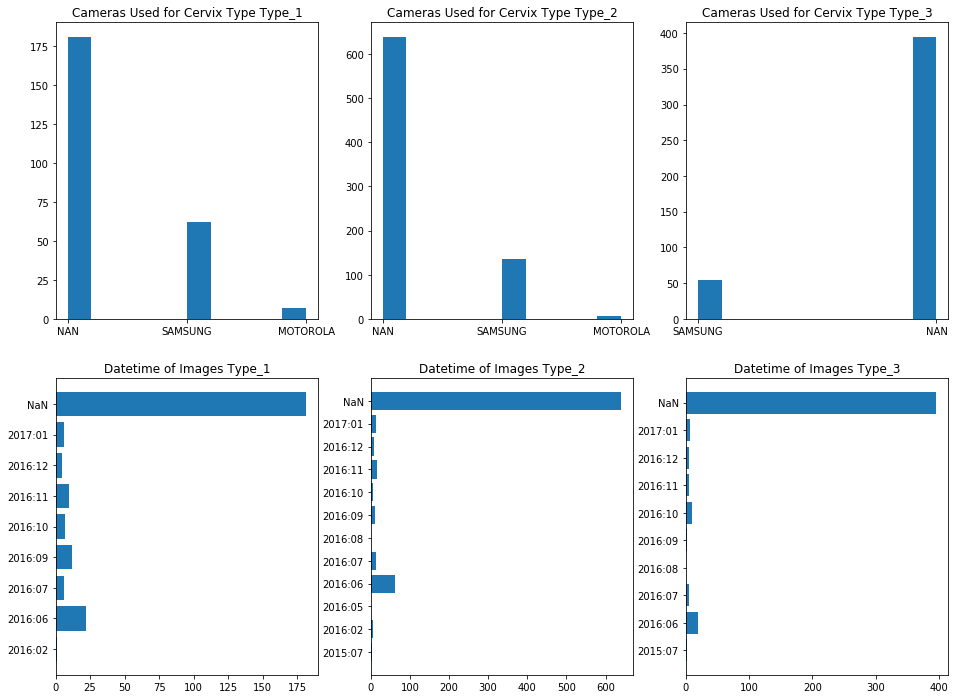

In [11]:
fig = plt.figure(figsize=(16,12))
for i, t in enumerate(train.type.unique()):
    df = train[train.type==t]
    paths = df.imagepath
    train_make = []
    train_datetime = []
    for path in paths:
        exif_dict = get_exif(path)
        if exif_dict == 'NaN':
            train_make.append('NaN')
            train_datetime.append('NaN')
        else:
            train_make.append(exif_dict['Make'])
            train_datetime.append(exif_dict['DateTime'][:7])
    ax1 = fig.add_subplot(2, 3, i+1)
    train_make = [x.upper() for x in train_make]
    ax1.hist(train_make)
    ax1.set_title('Cameras Used for Cervix Type {}'.format(t))
    ax2 = fig.add_subplot(2, 3, i+4)
    date, count = np.unique(train_datetime, return_counts= True)
    ax2.barh(date, count)
    ax2.set_title('Datetime of Images {}'.format(t))

### EXIF metadata for test set

In [12]:
test_make = []
test_datetime = []
for path in test_paths:
    exif_dict = get_exif(path)
    if exif_dict == 'NaN':
        test_make.append('NaN')
        test_datetime.append('NaN')
    else:
        test_make.append(exif_dict['Make'])
        test_datetime.append(exif_dict['DateTime'][:7])

In [13]:
test_make = [x.upper() for x in test_make]
date, count = np.unique(test_datetime, return_counts = True)

Text(0.5,1,'Images Taken by Month and Year')

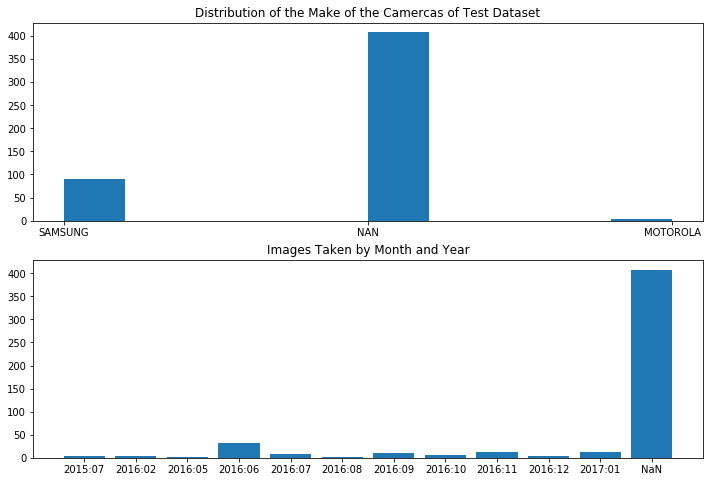

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax1.hist(test_make)
ax1.set_title('Distribution of the Make of the Camercas of Test Dataset')
ax2 = fig.add_subplot(2,1,2)
ax2.bar(sorted(date), count)
ax2.set_title('Images Taken by Month and Year')

According to all the histogram plots and bar graphs above, if we ignore the NaN data, all images were either taken by Samsung or Motorola. June of 2016 seems to be the time that the majority of images were collected. Let's now explore if there is any difference in term of image resolution between those taken by SAMSUNG versus those taken by MOTOROLA. 

## III. Inferential Statistics for image resolution difference between different cameras.

+ Null hypothesis: (H<sub>0</sub>) There is no difference in the mean high resolution between the images taken by Samsung and those taken by Motorola. 
+ Alternative hypothesis (H<sub>a</sub>) There is a significant difference in the mean high resolution between the images taken by Samsung and those taken by Motorola.

To tackle this inferential statistical analysis, let's set the statistical significance alpha = 0.05. Then, we need to extract data for images taken only by each camera seperately. Then, we will have to look at the size of the dataset to determine which frequentist statistical method should be used. We can then compare to bootstrap method. 

In [15]:
#Prepping data for generating a dataframe for the exif metadata
makes = []
datetime = []
for path in train.imagepath.values: 
    exif_data = get_exif(path)
    if exif_data == 'NaN':
        make = np.nan
        makes.append(make)
        datetime.append(np.nan)
    else:
        make = exif_data['Make'].upper()
        makes.append(make)
        datetime.append(exif_data['DateTime'])
exif_make = {'make': makes, 
             'datetime': datetime,
             'type': train.type.values, 
             'width': train.widths.values, 
             'height': train.heights.values}

In [16]:
#Create a dataframe for exif metadata
exif_df = pd.DataFrame(exif_make)
exif_df['img_size'] = exif_df.width*exif_df.height
exif_df.head()

,make,datetime,type,width,height,img_size
0,NaN,NaN,Type_1,2448,3264,7990272
1,NaN,NaN,Type_1,2448,3264,7990272
2,NaN,NaN,Type_1,3096,4128,12780288
3,SAMSUNG,2016:12:02 19:03:37,Type_1,2448,3264,7990272
4,SAMSUNG,2016:06:23 12:43:01,Type_1,3096,4128,12780288


In [17]:
#Drop nan rows
exif_df.dropna(how='any', inplace=True)
exif_df.head()

,make,datetime,type,width,height,img_size
3,SAMSUNG,2016:12:02 19:03:37,Type_1,2448,3264,7990272
4,SAMSUNG,2016:06:23 12:43:01,Type_1,3096,4128,12780288
11,SAMSUNG,2016:09:13 15:25:41,Type_1,3096,4128,12780288
12,SAMSUNG,2016:10:11 14:05:58,Type_1,2448,3264,7990272
14,SAMSUNG,2017:01:24 18:36:20,Type_1,2448,3264,7990272


In [18]:
samsung_df = exif_df[exif_df.make=='SAMSUNG']
motorola_df = exif_df[exif_df.make=='MOTOROLA']
print ('There are {}'.format(len(samsung_df)), 'data points in the Samsung dataframe')
print ('There are {}'.format(len(motorola_df)), 'data points in the Motorola dataframe')

There are 252 data points in the Samsung dataframe
There are 14 data points in the Motorola dataframe


There is a big difference between the sample size of the samsung dataframe (252) versus that of the motorola dataframe (14). The sample size of the motorola is less than 30 so we will need to conduct a two-tailed t test to compare the two population means. 

#### Test difference in image sizes using frequentist approach

In [22]:
import scipy.stats as stats
samsung_mean = np.mean(samsung_df.img_size)
motorola_mean = np.mean(motorola_df.img_size)


mean_diff = samsung_mean - motorola_mean
std_diff = (np.var(samsung_df.img_size)/len(samsung_df) + np.var(motorola_df.img_size)/len(motorola_df))**0.5
t_diff = mean_diff/std_diff
degree_of_freedom = len(samsung_df)+len(motorola_df) - 2
p_diff = (1- stats.t.cdf(abs(t_diff), df=degree_of_freedom))*2 

print('The t-value is %f' %t_diff, ' and the corresponding p-value is %f' %p_diff)
if p_diff < 0.05:
    print('Since the p-value is less than alpha=0.05, we reject the null hypothesis.')
else:
    print('Since the  p-value is greater than alpha=0.05, we fail to reject the null hypothesis.')

The t-value is -1.106102  and the corresponding p-value is 0.269689
Since the  p-value is greater than alpha=0.05, we fail to reject the null hypothesis.


Based on the above frequentist two-tailed t test, there is no statistical significance difference between the sizes of images taken by Samsung versus that of motorola. Let's now repeat the test using bootstrap hypothesis method

#### Testing difference in image sizes using bootstrap hypothesis testing 

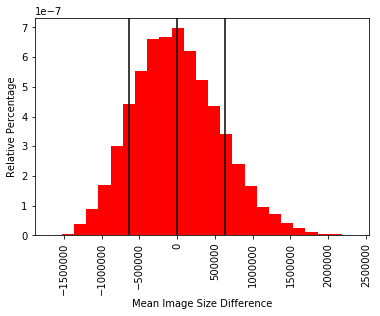

In [23]:
#Define number of times for bootstrapping
size = 10000

#Now, lets shift the mean of image sizes from both dataframe to be the same so we can work under the assumption 
#that the null hypothesis is true
mean_concat = np.mean(exif_df.img_size)
samsung_shifted = samsung_df.img_size - samsung_mean + mean_concat
motorola_shifted = motorola_df.img_size - motorola_mean + mean_concat

#Compute 10.000 bootstrap replicates from shited dataset
def draw_bs_replicates(data, func, size):
    #Initialize array of replicates 
    bs_replicates = np.empty(size)
    for i in range(size):
        # Generate bootstrap sample: bs_sample
        bs_sample = np.random.choice(data, len(data))
        #Calculate the mean of bootstrap sample
        rep = func(bs_sample)
        bs_replicates[i] = rep
    return bs_replicates

bs_replicates_samsung = draw_bs_replicates(samsung_shifted, np.mean, size)
bs_replicates_motorola = draw_bs_replicates(motorola_shifted, np.mean, size)

#Get replicates of difference of means:
bs_replicates = bs_replicates_samsung - bs_replicates_motorola

#Compute and print p-value
lower_bound = mean_diff
upper_bound = np.mean(bs_replicates) - mean_diff
p1 = np.sum(bs_replicates <= lower_bound)/len(bs_replicates)
p2 = np.sum(bs_replicates >= upper_bound)/len(bs_replicates)
p_val = p1+p2

#plot both histogram of bs_replicates and upper/lowerbound
plt.hist(bs_replicates, bins =25, normed=True, color='r')
plt.xlabel('Mean Image Size Difference')
plt.xticks(rotation=90)
plt.ylabel('Relative Percentage')
plt.axvline(x=0, color='k')
plt.axvline(x=lower_bound, color='k')
plt.axvline(x=upper_bound, color='k')
plt.show()

In [24]:
if p_val < 0.05:
    print('Since the p-value is less than alpha=0.05, we reject the null hypothesis.')
else:
    print('Since the  p-value is greater than alpha=0.05, we fail to reject the null hypothesis.')

Since the  p-value is greater than alpha=0.05, we fail to reject the null hypothesis.


Based on the above bootstrap hypothesis two-tailed  test, there is no statistical significance difference between the sizes of images taken by Samsung versus that of motorola, which is the same result obtained by conducting the t two-tailed test at alpha=0.05. 

## IV. EDA for the Training Dataset

Let's now take a look at the average image for each cervix type of the train set and the average image of the test dataset. In addition, we are also curious which image is the min or max based on ranking the norms of the image vectors. 

In [25]:
#Take a brief look at the structure of the train images dataframe
train_df.head()

,type,img_array
0,Type_1,"[[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,..."
1,Type_1,"[[85, 97, 100, 109, 112, 122, 125, 132, 136, 1..."
2,Type_1,"[[229, 225, 226, 223, 223, 226, 230, 228, 232,..."
3,Type_1,"[[162, 150, 157, 157, 153, 153, 158, 163, 161,..."
4,Type_1,"[[34, 39, 52, 67, 59, 69, 79, 82, 96, 108, 109..."


#### Average Image for Each Cervix Type

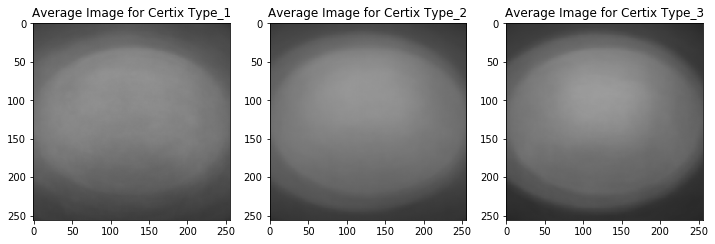

In [26]:
fig = plt.figure(figsize=(12,8))
for i, t in enumerate(train_df.type.unique()):
    ax = fig.add_subplot(1,3,i+1)
    img_list = train_df[train_df.type==t]['img_array']
    arr = np.zeros((h, w), np.float)
    for img in img_list:
        arr = arr + img/len(img_list)
    arr = np.array(np.round(arr), dtype=np.uint8)
    out = Image.fromarray(arr)
    plt.imshow(out)
    plt.title('Average Image for Certix {}'.format(t))  

It appears that the average image Type_1 cervix has the lightest contrast in comparison to the average images of the other types based on grayscale images. 

#### Find Min and Max Image Based on Norm Vectors

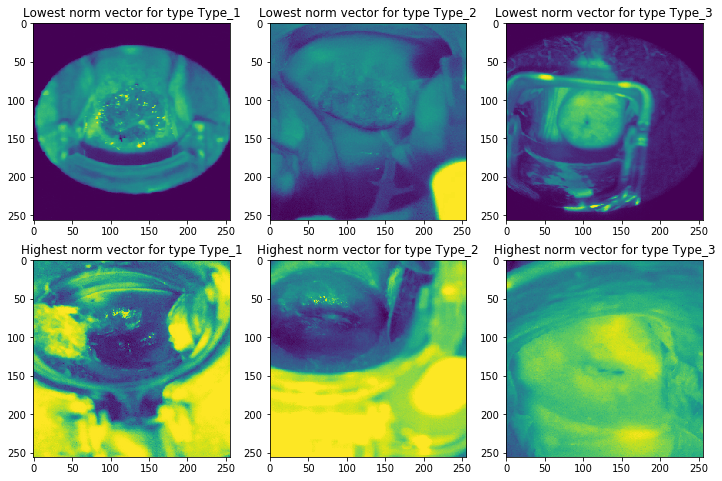

In [27]:
fig = plt.figure(figsize=(12,8))
for i, t in enumerate(train_df.type.unique()):
    ax1 = fig.add_subplot(2,3,i+1)
    ax2 = fig.add_subplot(2,3,i+4)
    norms = [[], [], []]
    for value in train_df[train_df.type == t].img_array.values:
        norm = np.linalg.norm(value)
        norms[i].append(norm)
    ax1.imshow(train_df[train_df.type==t].img_array.values[norms[i].index(min(norms[i]))])
    ax1.set_title('Lowest norm vector for type {}'.format(t))
    ax2.imshow(train_df[train_df.type==t].img_array.values[norms[i].index(max(norms[i]))])
    ax2.set_title('Highest norm vector for type {}'.format(t))


Based on the min and max images found by ranking the norms, the min images of all three types have darker features while the max images have brighter features based on grayscale images.

## V. EDA for the Test Dataset

#### Average Image for the Test Dataset

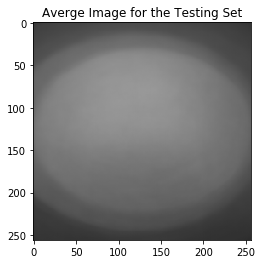

In [28]:
arr = np.zeros((h, w), np.float)
for img in test_imgs:
    arr = arr + img/len(test_imgs)
arr = np.array(np.round(arr), dtype=np.uint8)
out = Image.fromarray(arr)
plt.title('Averge Image for the Testing Set')
plt.imshow(out)

#### Finding Min and Max Mmage from Test Dataset Based on Norm Vector

Text(0.5,1,'Max_Test_Image')

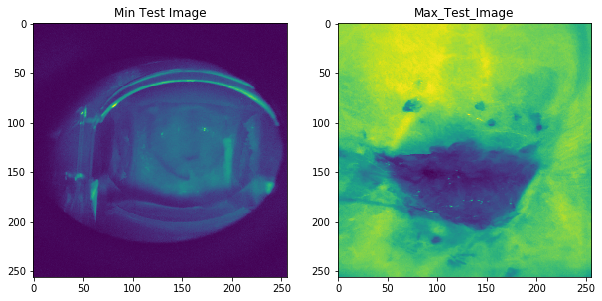

In [29]:
test_norms = []
for img in test_imgs:
    test_norm = np.linalg.norm(img)
    test_norms.append(test_norm)
min_test_norm = min(test_norms)
max_test_norm = max(test_norms)

min_tnorm_index = test_norms.index(min_test_norm)
max_tnorm_index = test_norms.index(max_test_norm)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(test_imgs[min_tnorm_index])
ax1.set_title('Min Test Image')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(test_imgs[max_tnorm_index])
ax2.set_title('Max_Test_Image')

The same behaviors are observed in the case of the test dataset: max image seems to have lighter features and min image has much darker features. 

## VI. Structrual Similarity Index (SSIM) 

In order to compare whether two different images have any similarity in their structures, we can use SSIM as an evaluation. Structural similarity index (SSIM) is calculated based on the following formula: ![](https://www.pyimagesearch.com/wp-content/uploads/2014/06/compare_ssim.png)
where: 

+ $\mu_x$ is the average of x
+ $\mu_y$ is the average of y
+ $\sigma^2_x$ is the variance of x
+ $\sigma^2_y$ is the variance of y
+ $c_1 = (k_1L)^2, c_2 = (k_2L)^2$ are the two variables to stablize the division with weak denominator
+ $L$ is the dynamic range of the pixel-values 
+ $k_1=0.01, k_@=0.03$ by default

SSIM keeps track of the structural information of the images and thus can be used to compare the similarity in structures of a given set of images data. SSIM value can vary between -1 and 1, where 1 indicates perfect similarity. SSIM can be calculated via implementing the scikit-image package of Python. 

In [30]:
from skimage.measure import compare_ssim

start_time = time.time()
ssims_train_type1 = []
for img in train_df[train_df.type=='Type_1'].img_array:
    img1 = img
    ssim = []
    for img2 in train_df[train_df.type=='Type_1'].img_array:
        s = compare_ssim(img1, img2)
        ssim.append(s)
    ssims_train_type1.append(ssim)
end_time = time.time()
print(end_time - start_time)

938.4572758674622


Since calculating the ssim for all the images of cervix type 1 from the training dataset took about 20 mins, we will only focus on analyzing the ssim of this subset data for this section. 

In [31]:
type1_names = train[train.type=='Type_1'].imagepath.values
type1_names = [x[13:].split('.')[0] for x in type1_names]

In [32]:
ssims_type1 = {}
for i, name in enumerate(type1_names):
    ssims_type1[name] = ssims_train_type1[i]
ssims_type1 = pd.DataFrame(ssims_type1, index=type1_names)

In [33]:
ssims_type1.head()

,0,1013,1014,1019,1023,1024,1026,1027,102,1033,...,928,930,965,96,972,977,982,984,991,998
0,1.000000,0.247682,0.296297,0.252564,0.285843,0.303511,0.196524,0.219119,0.286274,0.240576,...,0.197795,0.234890,0.255025,0.329415,0.263117,0.223555,0.306226,0.300739,0.246321,0.328504
1013,0.247682,1.000000,0.357942,0.346170,0.343276,0.186555,0.270189,0.150391,0.180054,0.345794,...,0.221871,0.288464,0.300963,0.397099,0.302457,0.306038,0.194697,0.379943,0.147154,0.410327
1014,0.296297,0.357942,1.000000,0.303280,0.374124,0.158599,0.285225,0.123558,0.189845,0.334808,...,0.276363,0.274712,0.322897,0.455860,0.291855,0.327344,0.194974,0.450099,0.134801,0.478059
1019,0.252564,0.346170,0.303280,1.000000,0.387033,0.185257,0.254797,0.184294,0.186494,0.293015,...,0.211302,0.335639,0.339312,0.372385,0.325724,0.340840,0.157888,0.365047,0.167496,0.404349
1023,0.285843,0.343276,0.374124,0.387033,1.000000,0.165818,0.210413,0.144845,0.195982,0.332633,...,0.225620,0.340151,0.346324,0.438505,0.338990,0.386269,0.174737,0.422759,0.199628,0.483328


Text(0.5,1,'SSIM Heatmap of All Type_1 Cervix Images')

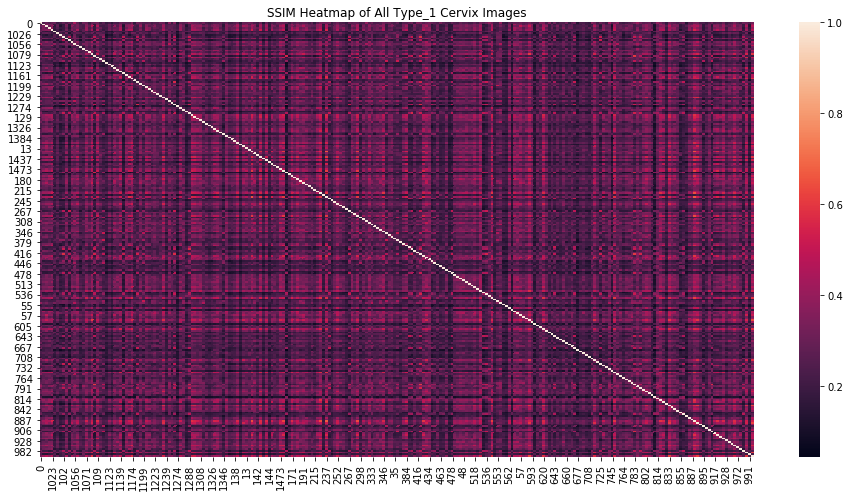

In [38]:
import seaborn as sns

fig = plt.subplots(figsize=(16,8))
fig = sns.heatmap(ssims_type1)
fig.set_title('SSIM Heatmap of All Type_1 Cervix Images')

The above plot is a heatmap which shows the ssim between two images of cervix type 1 from the training dataset. The darker the color, the less that particular image has any structural similarity to the compared image. It appears that the region of the images (620-708) has a bit darker intensity than the other regions. This fact indicates these images potentially have less structural similairty in comparison to the other images. 

# CONCLUSIONS:
+ The images were mainly taken by either Motorola or Samsung cameras. Even though the images were not taken by the same make/model, the inferential statistical analysis showed that there is no difference in term of image resolution across all images of both the training and the testing dataset. 
+ According to the bar charts generated for each cervix type of the training dataset, June 2016 seems to be the timeframe that a majority of images were taken. 
+ When comparing among the average images of the three cervix types of the training dataset, it appears that Type 1 has the brightest features (least color contrast). 
+ Finally, by constructing a ssim heatmap, we could potentially identify a region of images that have less structureal similarity to the other images. 

####  The next of this project would be to develop a model selection to build an effective algorithm. 